# EnsembleSwarm calorie burn regression

In [11]:
import pickle
import h5py
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ensembleset.dataset import DataSet
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor

%cd ..
from ensembleswarm.swarm import Swarm

/workspaces


## 1. Load and prepare data

In [2]:
data_df=pd.read_csv('examples/example_data/calories.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [3]:
data_df.drop('id', axis=1, inplace=True, errors='ignore')
train_df, test_df=train_test_split(data_df, test_size=0.5)
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375000 entries, 0 to 374999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         375000 non-null  object 
 1   Age         375000 non-null  int64  
 2   Height      375000 non-null  float64
 3   Weight      375000 non-null  float64
 4   Duration    375000 non-null  float64
 5   Heart_Rate  375000 non-null  float64
 6   Body_Temp   375000 non-null  float64
 7   Calories    375000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 22.9+ MB


## 2. EnsembleSwarm model

### 2.1. Generate ensembleset

In [4]:
ensemble_members=100

# data_ensemble=DataSet(
#     label='Calories',
#     train_data=train_df,
#     test_data=test_df,
#     string_features=['Sex'],
#     data_directory='ensembleset_data'
# )

# data_ensemble.make_datasets(
#     n_datasets=ensemble_members,
#     frac_features=0.7,
#     n_steps=3
# )

### 2.2. Train swarm

In [6]:
%%time

# swarm=Swarm(ensembleset = 'ensembleset_data/ensembleset.h5')
# swarm.optimize_swarm(sample = 10000)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 7.15 μs


### 2.3. Swarm predictions

In [10]:
level_two_dataset={}
swarm_rmsle={
    'model': [],
    'ensemble': [],
    'RMSLE': []
}

with h5py.File('ensembleset_data/ensembleset.h5', 'r') as hdf:

    num_datasets=len(list(hdf['train'].keys())) - 1
    print(f"Testing datasets: {list(hdf['test'].keys())}")
    print(f'Will generate swarm output for {num_datasets} datasets')

    for i in range(4):
        models=glob.glob(f'ensembleswarm_models/swarm/{i}/*.pkl')

        for _, model_path in enumerate(models):
            model_type = model_path.split('/')[-1]
            model_type = model_type.split('.')[0]

            with open(model_path, 'rb') as input_file:
                model = pickle.load(input_file)

            if model is not None and isinstance(model, dict) == False:
                print(f'Generating test output for ensemble {i}, {model_type}')

                predictions = model.predict(hdf[f'test/{i}'][:])
                level_two_dataset[f'{i}_{model_type}']=predictions.flatten()

                rmsle = np.sqrt(
                    mean_squared_log_error(
                        hdf['test/labels'][:], 
                        np.where(predictions >= 0, predictions, 0)
                    )
                )

                swarm_rmsle['ensemble'].append(i)
                swarm_rmsle['model'].append(model_type)
                swarm_rmsle['RMSLE'].append(rmsle)

    level_two_dataset['label'] = np.array(hdf['test/labels'])
    level_two_df = pd.DataFrame.from_dict(level_two_dataset)

swarm_rmsle_df = pd.DataFrame.from_dict(swarm_rmsle)

Testing datasets: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'labels']
Will generate swarm output for 100 datasets
Generating test output for ensemble 0, linear_regression
Generating test output for ensemble 0, linear_svm
Generating test output for ensemble 0, decision_tree
Generating test output for ensemble 0, nearest_neighbors
Generating test output for ensemble 0, sgd
Generating test output for ensemble 0, rbf_svm
Generating test output for ens

### 2.4. Swarm RMSLE distribution

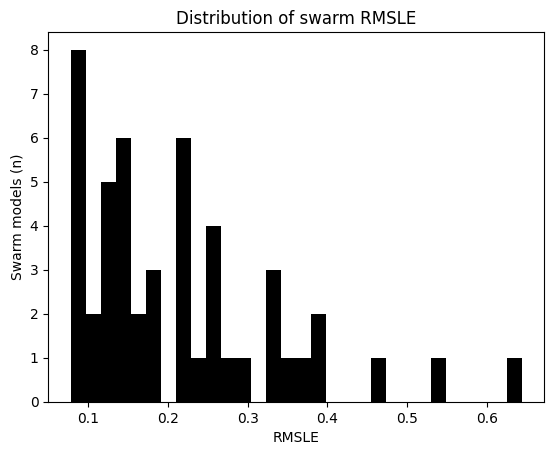

In [ ]:
plt.title('Distribution of swarm RMSLE')
plt.hist(swarm_rmsle_df['RMSLE'], color='black', bins=30)
plt.xlabel('RMSLE')
plt.ylabel('Swarm models (n)')
plt.show()

### 2.5. Individual model scores

### 2.5. Level II model cross-validation

In [14]:
scores=cross_val_score(
    HistGradientBoostingRegressor(loss='gamma'),
    level_two_df.drop('label', axis=1),
    level_two_df['label'],
    scoring='neg_mean_squared_log_error',
    n_jobs=-1,
    cv=7
)

print(f'Cross-validation RMSLE: {np.mean(np.sqrt(-scores)):.4f} +/- {np.std(np.sqrt(-scores)):.4f}')

Cross-validation RMSLE: 0.0630 +/- 0.0010
